<a href="https://colab.research.google.com/github/Yet-nde/CMM500-CODES/blob/main/Experiment_Random_Forest_model_selection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Reset potentially conflicting variables
for _name in ['X','y','X_train','X_val','X_test','y_train','y_val','y_test','df', 'df_2012','session_cols']:
    if _name in globals():
        del globals()[_name]

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, time, shap

#preprocessing & modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate,GroupShuffleSplit, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score, precision_recall_curve,average_precision_score, roc_curve,auc)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from scipy.stats import entropy

#visualisation
%matplotlib inline
sns.set(style="whitegrid")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
folder_path = "/content/drive/MyDrive/2012dataset"

In [5]:
file_paths={
    'Sat':f'{folder_path}/TestbedSatJun12Flows.csv',
    'Sun':f'{folder_path}/TestbedSunJun13Flows.csv',
    'Mon':f'{folder_path}/TestbedMonJun14Flows.csv',
    'Tue':f'{folder_path}/TestbedTueJun15Flows.csv',
    'Wed':f'{folder_path}/TestbedWedJun16Flows.csv',
    'Thu':f'{folder_path}/TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

In [6]:
df['session_id'] = (
    df['source'].astype(str) + '_' +
    df['destination'].astype(str) + '_' +
    df['sourcePort'].astype(str) + '_' +
    df['destinationPort'].astype(str) + '_' +
    df['protocolName'].astype(str) + '_' +
    df['direction'].astype(str)
)
df.head()


,generated,appName,totalSourceBytes,totalDestinationBytes,totalDestinationPackets,totalSourcePackets,sourcePayloadAsBase64,sourcePayloadAsUTF,destinationPayloadAsBase64,destinationPayloadAsUTF,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,source,protocolName,sourcePort,destination,destinationPort,startDateTime,stopDateTime,Label,day,session_id
0,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22441,216.246.64.49,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.49_22441_80_tcp_ip_L2R
1,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22445,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.66_22445_80_tcp_ip_L2R
2,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22444,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.1.104_216.246.64.66_22444_80_tcp_ip_L2R
3,3/11/2014 17:23,SSH,2938,49570,76,27,NaN,NaN,NaN,NaN,L2L,"S,R,P,A","S,P,A",192.168.3.115,tcp_ip,3248,192.168.5.122,22,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.3.115_192.168.5.122_3248_22_tcp_ip_L2L
4,3/11/2014 17:23,HTTPImageTransfer,644,2315,5,7,NaN,NaN,NaN,NaN,L2R,"S,P,A","S,P,A",192.168.2.110,tcp_ip,1867,142.166.14.77,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat,192.168.2.110_142.166.14.77_1867_80_tcp_ip_L2R


In [7]:
session_cols=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_cols+['Label','session_id']]
df=df.copy()

In [8]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

In [9]:
cat_cols=['sourceTCPFlagsDescription','destinationTCPFlagsDescription']
label_encoders = {}
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le

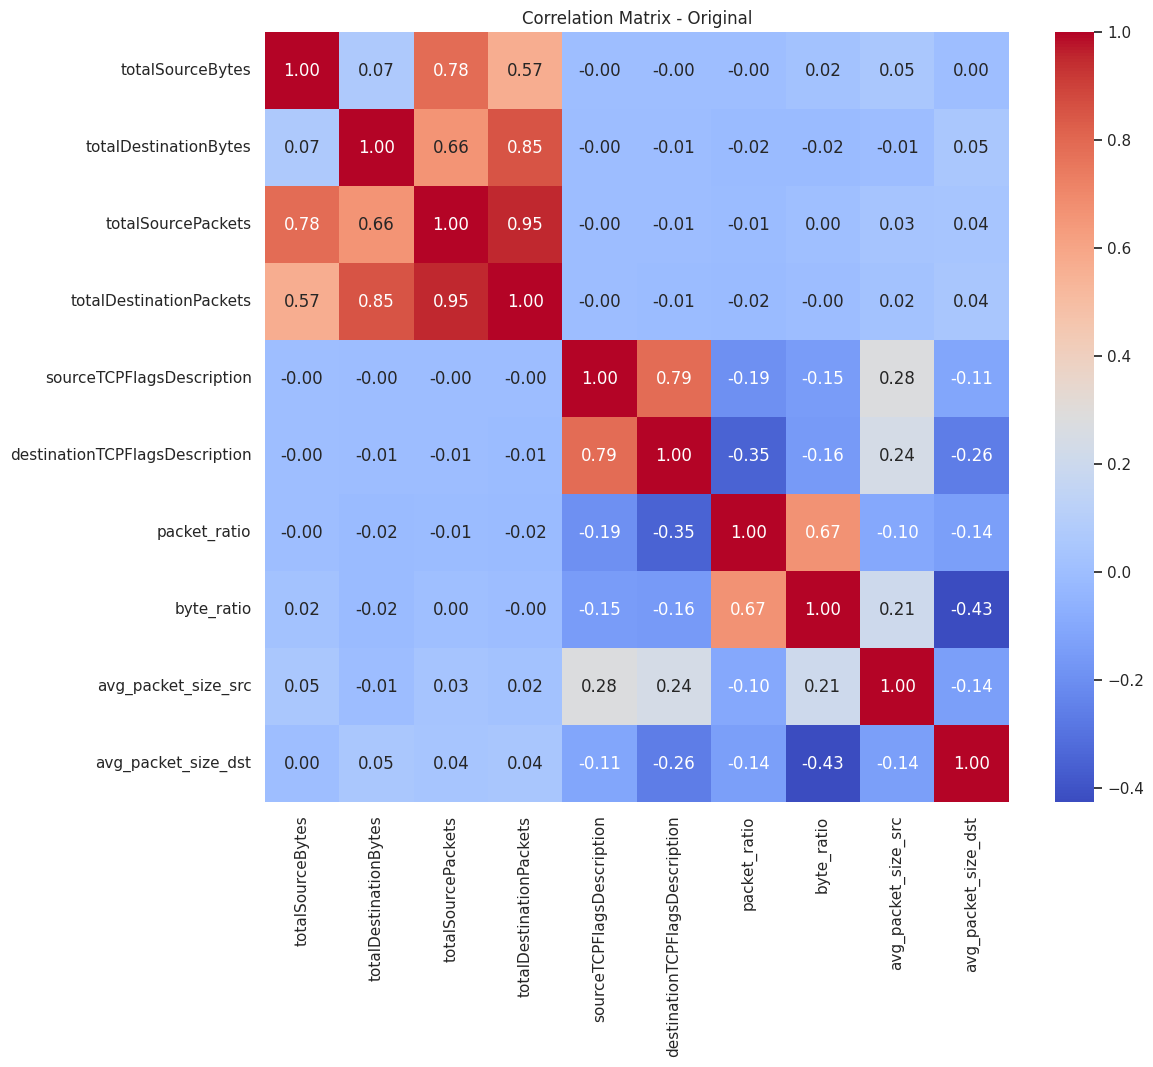

In [10]:
# Correlation matrix on original columns
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Original")
plt.show()

In [11]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced

In [12]:
df.head()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,sourceTCPFlagsDescription,destinationTCPFlagsDescription,Label,session_id,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst
0,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.49_22441_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
1,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.66_22445_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
2,128,64,2,1,1,1,Normal,192.168.1.104_216.246.64.66_22444_80_tcp_ip_L2R,2.000000,2.000000,64.000000,64.000000
3,2938,49570,27,76,22,22,Normal,192.168.3.115_192.168.5.122_3248_22_tcp_ip_L2L,0.355263,0.059270,108.814815,652.236842
4,644,2315,7,5,18,22,Normal,192.168.2.110_142.166.14.77_1867_80_tcp_ip_L2R,1.400000,0.278186,92.000000,463.000000


In [13]:
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model = pd.concat([df_reduced, df[["Label",'session_id']]], axis=1)

Dropped 1 columns due to high correlation: ['totalDestinationPackets']


In [14]:
X = df_model.drop(["Label",'session_id'], axis=1)
y = df_model["Label"].map({"Normal": 0, "Attack": 1})
groups=df_model['session_id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Unique sessions in Train: {len(set(groups.iloc[train_idx]))}")
print(f"Unique sessions in Test: {len(set(groups.iloc[test_idx]))}")


Training samples: 1659490
Testing samples: 412167
Unique sessions in Train: 881629
Unique sessions in Test: 220408



Baseline RF Training Set Evaluation:
              precision    recall  f1-score   support

           0     0.9990    0.9993    0.9991   1604429
           1     0.9792    0.9705    0.9748     55061

    accuracy                         0.9983   1659490
   macro avg     0.9891    0.9849    0.9870   1659490
weighted avg     0.9983    0.9983    0.9983   1659490

AUC: 0.9997
Average Precision: 0.9946
Confusion Matrix:
[[1603294    1135]
 [   1626   53435]]

Baseline RF Test Set Evaluation:
              precision    recall  f1-score   support

           0     0.9985    0.9992    0.9989    398318
           1     0.9761    0.9573    0.9666     13849

    accuracy                         0.9978    412167
   macro avg     0.9873    0.9783    0.9827    412167
weighted avg     0.9978    0.9978    0.9978    412167

AUC: 0.9987
Average Precision: 0.9922
Confusion Matrix:
[[397993    325]
 [   591  13258]]

Weighted RF Training Set Evaluation:
              precision    recall  f1-score   supp

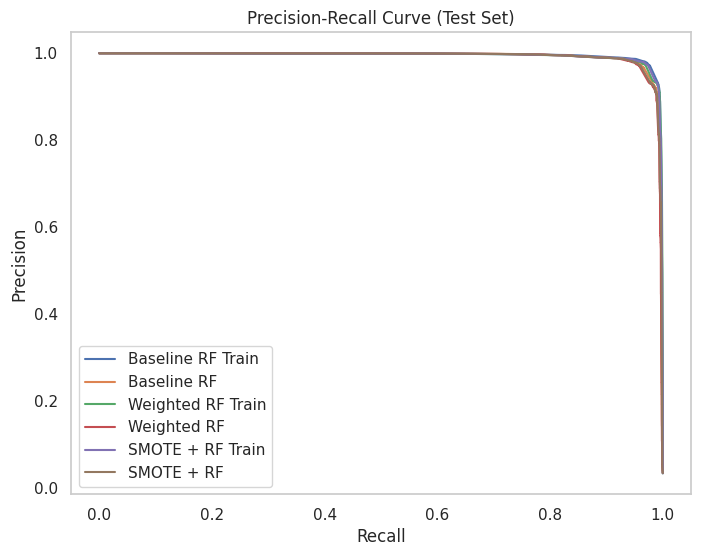

In [15]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    # Train metrics
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    print(f"\n{name} Training Set Evaluation:")
    print(classification_report(y_train, y_train_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_train, y_train_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))
    precision, recall, _ = precision_recall_curve(y_train, y_train_proba)
    plt.plot(recall, precision, label=f"{name} Train")

    # Test metrics
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Test Set Evaluation:")
    print(classification_report(y_test, y_pred,digits=4))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    return precision, recall

# Define models
rf_params = {'n_estimators': 50, 'max_depth': 15, 'n_jobs': -1, 'random_state': 42}
models = {
    "Baseline RF": RandomForestClassifier(**rf_params),
    "Weighted RF": RandomForestClassifier(class_weight='balanced', **rf_params),
    "SMOTE + RF": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(**rf_params))
    ])
}

# Fit and evaluate
plt.figure(figsize=(8, 6))
for name, model in models.items():
    precision, recall = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    plt.plot(recall, precision, label=name)

plt.title("Precision-Recall Curve (Test Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

In [16]:
def compare_models_cv(models, X, y, groups, scoring=None, cv=5,verbose=True):
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = {}
    gkf = GroupKFold(n_splits=cv)
    for name, model in models.items():
        cv_result = cross_validate(model, X, y, groups=groups, scoring=scoring, cv=gkf,return_train_score=True)
        mean_scores = {}
        for metric in scoring:
            mean_scores[f"train_{metric}"] = round(cv_result[f'train_{metric}'].mean(), 4)
            mean_scores[f"test_{metric}"] = round(cv_result[f'test_{metric}'].mean(), 4)

        results[name] = mean_scores

        if verbose:
            print(f"\n{name} scores:")
            for metric in scoring:
                print(f"  {metric}: train={mean_scores[f'train_{metric}']}, test={mean_scores[f'test_{metric}']}")

    return pd.DataFrame(results).T

# Run CV on training set only
cv_results = compare_models_cv(models, X_train, y_train, groups_train, cv=5)
print("\nCross-Validation Summary:")
display(cv_results)


Baseline RF scores:
  accuracy: train=0.9984, test=0.9979
  precision: train=0.9797, test=0.9739
  recall: train=0.971, test=0.9631
  f1: train=0.9753, test=0.9685
  roc_auc: train=0.9998, test=0.9986

Weighted RF scores:
  accuracy: train=0.9969, test=0.9965
  precision: train=0.9189, test=0.9147
  recall: train=0.9935, test=0.9865
  f1: train=0.9548, test=0.9492
  roc_auc: train=0.9998, test=0.9985

SMOTE + RF scores:
  accuracy: train=0.9967, test=0.9963
  precision: train=0.9143, test=0.9084
  recall: train=0.9929, test=0.9887
  f1: train=0.952, test=0.9468
  roc_auc: train=0.9997, test=0.9986

Cross-Validation Summary:


,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_roc_auc,test_roc_auc
Baseline RF,0.9984,0.9979,0.9797,0.9739,0.9710,0.9631,0.9753,0.9685,0.9998,0.9986
Weighted RF,0.9969,0.9965,0.9189,0.9147,0.9935,0.9865,0.9548,0.9492,0.9998,0.9985
SMOTE + RF,0.9967,0.9963,0.9143,0.9084,0.9929,0.9887,0.9520,0.9468,0.9997,0.9986
